In [ ]:
# To do:
# special thank you to ... 
# create markdown sections (including fMRIPrep website, nilearn website etc.) and put references
# improve comments and add print statements to facilitate human understanding
# add error tests
# Different pipelines have different n of participants - remove extra participants:
    # exclude M006, M107, M108

In [ ]:
# This script is to be used on pre-processed fMRI timeseries data 

In [1]:
# Import all of the necessary modules and libraries

import glob
import os

import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import statannot
from statannot import add_stat_annotation

import xlrd
import itertools

import nibabel as nib
from nilearn import image
from nilearn import plotting
from nilearn import datasets
from nilearn import input_data
from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import atlas with ROIs to be used for the connectivity analysis

# the MSDL (multi-subject dictionary learning; {cite}Varoquaux_2011) atlas defines a set of probabilistic ROIs across the brain.
# import a different atlas, if you prefer
#msdl_atlas = datasets.fetch_atlas_msdl()
#msdl_coords = msdl_atlas.region_coords
#n_regions = len(msdl_coords)
#print(f'MSDL has {n_regions} ROIs, part of the following networks :\n{np.unique(msdl_atlas.networks)}.')

# A non-probabilistic atlas (in the sense that it doesn't learn on your own data):
# check https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases
harv_oxf_atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
rois = harv_oxf_atlas.labels
n_regions = len(rois)
print(f'This atlas has {n_regions} ROIs.')

In [ ]:
# view the atlas
# plotting.plot_prob_atlas(msdl_atlas.maps)
plotting.plot_roi(harv_oxf_atlas.maps)

In [ ]:
# apply a NiftiMapsMasker as the MSDL atlas is probabilistic
# !! if you're using a deterministic atlas, then use a NiftiLabelsMasker object !!

#masker = input_data.NiftiMapsMasker(
#    msdl_atlas.maps, resampling_target="data",
#    t_r=2, detrend=True,
#    low_pass=0.1, high_pass=0.01).fit()

masker = input_data.NiftiLabelsMasker(
    harv_oxf_atlas.maps, resampling_target="data",
    t_r=2.5, detrend=True,
    low_pass=0.1, high_pass=0.01).fit()

In [ ]:
pipeline_list = sorted(glob.glob("/Volumes/Seagate Dr/PhD/Chapter 1/*"))
print(*pipeline_list, sep='\n')
print(type(pipeline_list))

In [ ]:
def quality_check(pipeline_list):
    for n in range(len(pipeline_list)):
        current_pipeline = pipeline_list[n]
        print(current_pipeline)
        fmri_img_path = os.path.join(current_pipeline, "*.gz")
        print(fmri_img_path)
        fmri_img = sorted(glob.glob(fmri_img_path))
        print(*fmri_img, sep='\n')
        # check the dimensions of a single participant fMRI data to see if it makes sense!
        fmri_img_single = nib.load(fmri_img[0])
        print(fmri_img_single.shape)

In [ ]:
quality_check(pipeline_list)

In [ ]:
# to look at the mean fMRI brain image for a single participant
# !!!!!!!!!!! ADD THE OTHER LINES !!!!!!!!!!!!!!
# change this line to get your data!
mean_image = image.mean_img(fmri_img_single)
plotting.view_img(mean_image, threshold=None)

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!! TEST THIS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# calculate the connectivity matrices and the mean functional connectivity (mFC) values (across the brain) for all participants


# create a function that will execute the connectivity analysis and calculate mFC values
def calc_conn_mFC(pipeline_list):
    # choose a pipeline
    for p in range(len(pipeline_list)):
        current_pipeline = pipeline_list[p]
        print("Current pipeline:", current_pipeline)
        #set the list of fMRI files
        fmri_img_path = os.path.join(current_pipeline, "*.gz")
        print(fmri_img_path)
        fmri_img = sorted(glob.glob(fmri_img_path))
        # initiate an empty list that will contain a single mFC value for each participant
        mFC_list = []
        # specify for the number of participants you have
        for n in range(len(fmri_img)):
            # check if this is the right participant
            print("Working on participant:")
            print(fmri_img[n])
            # !!!!!! change this line to get your data !!!!!!!
            # !! it is recommended to remove confounds by using the confounds= option and selecting them from your confounds file
            # it is also a good idea to compare the corrected and uncorrected connectivity matrices
            roi_time_series = masker.transform(fmri_img[n])        
            # calculate a connectivity matrix
            # choose a type of correlation analysis, tangent space embedding is recommended, but it requires that the program is run on all subjects simultaneously
            correlation_measure = ConnectivityMeasure(kind='correlation')
            correlation_matrix = correlation_measure.fit_transform([roi_time_series])[0]
            print("Connectivity matrix calculated.")
            # save the matrix to a csv file, using subject n
            # N.B. matrix file will not have column and row names, i.e. the brain region names. 
            # They have to be added from the atlas that was used for the connectivity analysis when doing the plotting, for instance
            np.savetxt('pipeline'+str(p)+'sub_'+str(n)+'_conn_matrix.csv', correlation_matrix, delimiter=',')
            print('Connectivity matrix for sub'+str(n)+' saved.')
            # calculate mFC and append value to the mFC_list
            mFC = mean(correlation_matrix)
            mFC_list.append(mFC)
            print('mFC_list updated.')
        print('Pipeline'+str(p)+' Analysis Completed.')
        mFC_list = np.array(mFC_list)
        np.savetxt('mFC_list_pipeline'+str(p)+'.csv', mFC_list, delimiter=',')
        print('mFC_list_pipeline'+str(p)+'.csv saved.')
    print("Done.")


In [ ]:
#run the FC function
calc_conn_mFC(pipeline_list)

In [ ]:
# import pandas as pd
# import specific correlation matrix csv files
# or the mFC_list file (especially after kernel restart)
conn_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/pipeline0sub_0_conn_matrix.csv', delimiter=',', header=None)
print(conn_matrix)
print(type(conn_matrix))

In [ ]:
# plot a connectivity matrix
# set this to a matrix of your choice
correlation_matrix = conn_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
# Or view it as an embedded connectome:
plotting.view_connectome(correlation_matrix, edge_threshold=0.2,
                         node_coords=msdl_atlas.region_coords)

In [ ]:
# import pandas as pd
# import a mFC_list file (especially after kernel restart)
mFC_list = pd.read_csv('~/Downloads/PhD/Analysis/QC/mFC_list_pipeline0.csv', delimiter=' ', header=None)
print(mFC_list)
print(type(mFC_list))

In [ ]:
pipeline_list_FD = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/FD/*"))
print(*pipeline_list_FD, sep='\n')
print(type(pipeline_list))

In [ ]:
def calc_mFD(pipeline_list):
    # choose a pipeline
    for p in range(len(pipeline_list)):
        current_pipeline = pipeline_list[p]
        print("Current pipeline:", current_pipeline)
        #set the list of FD files
        FD_path = os.path.join(current_pipeline, "*.txt")
        print(FD_path)
        FD_files = sorted(glob.glob(FD_path))
        # initiate an empty list that will contain a single mFD value for each participant
        mFD_list = []
        # specify for the number of participants you have
        for n in range(len(FD_files)):
            # check if this is the right participant
            print("Working on participant:")
            print(FD_files[n])
            FD = pd.read_table(FD_files[n])
            print("This is the FD data:")
            print(FD)
            # calculate mFD and append value to the mFD_list
            mFD = mean(FD)
            print("mFD =",mFD)
            mFD_list.append(mFD)
            print("mFD list updated.")
        print('Pipeline'+str(p)+' Analysis Completed.')
        mFD_list = np.array(mFD_list)
        np.savetxt('mFD_list_pipeline'+str(p)+'.csv', mFD_list, delimiter=',')
        print('mFD_list_pipeline'+str(p)+'.csv saved.')
    print("Done.")

In [ ]:
calc_mFD(pipeline_list_FD)

In [ ]:
# import a mFD_list file (especially after kernel restart)
mFD_list = pd.read_csv('~/Downloads/PhD/Analysis/QC/mFD_list_pipeline2.csv', delimiter=' ', header=None)
print(mFD_list)
print(type(mFD_list))

In [ ]:
# plot the mFD values for all pipelines

In [ ]:
mFdisp_list = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mFD_list_pipeline*"))
mFD_list = []
for n in range(len(mFdisp_list)):
    mFD_list_single = pd.read_csv(mFdisp_list[n], delimiter=' ', header=None)
    mFD_list.append(mFD_list_single)
print(len(mFD_list))
print(len(mFD_list[10]))


In [ ]:
# check normality
for n in range(len(mFD_list)):
    plt.hist(mFD_list[n], bins = 8)
    plt.show()

In [ ]:
xls = xlrd.open_workbook(r'~/Downloads/PhD/Analysis/QC/ARB_QC.xlsx', on_demand=True)
pipeline_names = xls.sheet_names()
pipeline_names

In [ ]:
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots(figsize=(20,8))
mfd_figure = ax.boxplot(mFD_list, 
                          #notch=True, 
                          bootstrap=5000, 
                          showfliers=True)
ax.set_xticklabels(pipeline_names)
plt.show(mfd_figure)
#plt.savefig("dvars.png")

In [ ]:
# import matplotlib.pyplot as plot
# import numpy as np
# plot all correlations
mFconn_list = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mFC_list_pipeline*"))
mFdisp_list = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mFD_list_pipeline*"))

In [ ]:
# Check normality!!


In [ ]:
# the sorting is not done correctly!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
mFconn_list

In [ ]:
mFdisp_list

In [ ]:
for n in range(len(mFconn_list)):
    mFC_list_single = pd.read_csv(mFconn_list[n], delimiter=' ', header=None)
    mFD_list_single = pd.read_csv(mFdisp_list[n], delimiter=' ', header=None)
    plt.scatter(mFC_list_single, mFD_list_single)
    plt.title('mFD-mFC Correlation - Pipeline'+str(n))
    plt.xlabel('mFC')
    plt.ylabel('mFD')
    plt.show()

In [ ]:
for n in range(len(mFconn_list)):
    mFC_list_single = pd.read_csv(mFconn_list[n], delimiter=' ', header=None)
    # transpose it to make it work correctly with np.corrcoef
    mFC_list_single = mFC_list_single.T
    mFD_list_single = pd.read_csv(mFdisp_list[n], delimiter=' ', header=None)
    # transpose it to make it work correctly with np.corrcoef
    mFD_list_single = mFD_list_single.T
    r = np.corrcoef(mFC_list_single, mFD_list_single)
    print(n)
    print(r)

In [ ]:
r

In [ ]:
r[0,1]

In [ ]:
# ?????? Hypothesis testing ????
# ?????? Compare each to each other (like the DVARS)????

In [ ]:
# subject-specific edge-wise mFD-FC

In [ ]:
conn_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/pipeline0sub_2_conn_matrix.csv', delimiter=',', header=None)
conn_matrix

In [ ]:
# for pipeline 0:
# iterate through a specific edge for all 18 participants
# SHOULD I?????? ----- ...... !!!!!!!!!!!! if the FC values are above 0.25 !!!!!!!!!!!!
# correlate the 18 edge values with the 18 mFD values for that pipeline
# plot the distribution of 2304 values and get mean/median and 95%CI/quarters
# scale it up to include all pipelines
# plot only the mean/median and 95%CI/quarters for each separate pipeline

In [ ]:
#for i in range (len(conn_matrix)):
#    for j in range(len(conn_matrix)):
#        fc = conn_matrix.iloc[i, j]
#        r = np.corrcoef(fc, mFD_val)
#        conn_matrix.iloc[i, j] = r
#print(conn_matrix)

# vectorise the matrices instead??

In [ ]:
fconn_list = []
s_vals = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/pipeline2sub_?_conn_matrix.csv"))
ss_vals = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/pipeline2sub_??_conn_matrix.csv"))
for n in range(len(s_vals)):
    fconn_list.append(s_vals[n])
for n in range(len(ss_vals)):
    fconn_list.append(ss_vals[n])
fconn_list

In [ ]:
mFdisp_list = []
d_vals = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mFD_list_pipeline?.csv"))
dd_vals = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mFD_list_pipeline??.csv"))
for n in range(len(d_vals)):
    mFdisp_list.append(d_vals[n])
for n in range(len(dd_vals)):
    mFdisp_list.append(dd_vals[n])
mFdisp_list

In [ ]:
fd_pipe = pd.read_csv(mFdisp_list[2], delimiter=' ', header=None)
fd_pipe = np.array(fd_pipe)
type(fd_pipe)

In [ ]:
type(conn_matrix)

In [ ]:
# Initiate these to use for the range function
conn_matrix = pd.read_csv(fconn_list[2], delimiter=',', header=None)
conn_rows = conn_matrix.shape[0]
conn_cols = conn_matrix.shape[1]

In [ ]:
fd_pipe = fd_pipe.T
fd_pipe

In [ ]:
fd_pipe

In [ ]:
print(fd_pipe.shape[0])
print(fd_pipe.shape[1])

In [ ]:
corr_matrix

In [ ]:
corr_matrix.shape

In [ ]:
len(corr_matrix)

In [ ]:
# participant 14 is M113 who was dropped

fconn_list_complete = []
for n in range(12):
    fconn_list_s = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/pipeline"+str(n)+"sub_?_conn_matrix.csv"))
    fconn_list_ss = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/pipeline"+str(n)+"sub_??_conn_matrix.csv"))
    fconn_list_temp = []
    for n in range(len(fconn_list_s)):
        fconn_list_temp.append(fconn_list_s[n])
    for n in range(len(fconn_list_ss)):
        fconn_list_temp.append(fconn_list_ss[n])
    fconn_list_complete.append(fconn_list_temp)

In [ ]:
fconn_list_complete

In [ ]:
len(fconn_list_complete)

In [ ]:
# super crude... optimise this!!!

def calc_FC_mFD(fconn_list_complete):

    for p in range(len(fconn_list_complete)):
        # Initiate an empty matrix that would be filled with correlation values, i.e. mFD-FC values
        corr_matrix = pd.DataFrame(#index=range(0,1),
        columns=range(0,48))

        fconn_list = fconn_list_complete[p]
        for i in range(conn_rows):
            temp_corr_list = []
            for j in range(conn_cols):
                temp_fc_vals = []
                
                for n in range(len(fconn_list)):
                    # !! CHECK IF THE SUBJECT ORDER IS CORRECT !!
                    print("This is participant:" + fconn_list[n])
                    temp_conn_matrix = pd.read_csv(fconn_list[n], delimiter=',', header=None) 
                    edge = temp_conn_matrix.iloc[i,j]
                    #if edge > 0.25:
                        #temp_fc_vals.append(edge)
                    #else:
                        # what should I append
                        #temp_fc_vals.append(0)
                    temp_fc_vals.append(edge)
                    print("FC value appended.")
                temp_fc_vals = np.array(temp_fc_vals).reshape(17, 1).T
                print(temp_fc_vals)
                print(temp_fc_vals.shape)
                fd_pipe = pd.read_csv(mFdisp_list[p], delimiter=' ', header=None)
                fd_pipe = np.array(fd_pipe)
                fd_pipe = fd_pipe.T
                print(fd_pipe.shape)
                # Do correlation between temp fc values and the mFD values for current pipeline
                r = np.corrcoef(temp_fc_vals, fd_pipe)
                # Append only the actual r value, not the whole matrix
                print("r value is:")
                print(r[0,1])
                # append corr values to the corr_list
                temp_corr_list.append(r[0,1])
                print("temp_corr_list updated.")
            # append the whole list as the ith row in the corr_matrix
            corr_matrix.loc[len(corr_matrix)] = temp_corr_list
            print("corr_matrix updated.")
        np.savetxt('mfd-fc_pipeline'+str(p)+'_matrix.csv', corr_matrix, delimiter=',')
        print('mfd-fc_pipeline'+str(p)+'_matrix.csv saved.')
        print("Pipeline" + str(p) + " analysis completed.")
    print("Done.")
                    

In [ ]:
#%%timeit
calc_FC_mFD(fconn_list_complete)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline0_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline1_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline2_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline3_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline4_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline5_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline6_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline7_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline8_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline9_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline10_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
corr_matrix = pd.read_csv('~/Downloads/PhD/Analysis/QC/mfd-fc_pipeline11_matrix.csv', delimiter=',', header=None)
correlation_matrix = corr_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=0.8, vmin=-0.8, colorbar=True)

In [2]:
pipeline_src_s = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline?_matrix.csv"))
pipeline_src_ss = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline??_matrix.csv"))

pipeline_list_temp = []
pipeline_list = []

for n in range(len(pipeline_src_s)):
    pipeline_list_temp.append(pipeline_src_s[n])
for n in range(len(pipeline_src_ss)):
    pipeline_list_temp.append(pipeline_src_ss[n])
pipeline_list.append(pipeline_list_temp)
pipeline_list

[['/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline0_matrix.csv',
  '/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline1_matrix.csv',
  '/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline2_matrix.csv',
  '/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline3_matrix.csv',
  '/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline4_matrix.csv',
  '/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline5_matrix.csv',
  '/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline6_matrix.csv',
  '/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline7_matrix.csv',
  '/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline8_matrix.csv',
  '/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline9_matrix.csv',
  '/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline10_matrix.csv',
  '/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline11_matrix.csv']]

In [3]:
pipeline_list = np.array(pipeline_list)

In [4]:
pipeline_list[0,1]

'/Users/mishodimitrov/Downloads/PhD/Analysis/QC/mfd-fc_pipeline1_matrix.csv'

In [5]:
pipeline_list.shape[1]

12

In [ ]:
# plot matrices side by side to compare (and to include in supplementary section)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(50,25))
fig.subplots_adjust(hspace=0.5, wspace=2.5)
fig.suptitle('mFD-FC Comparison')

for i, ax in enumerate(axes.flatten()):
#for i in range(pipeline_list.shape[1]):
    corr_matrix = pd.read_csv(pipeline_list[0,i], delimiter=',', header=None)
    correlation_matrix = corr_matrix.to_numpy()
    np.fill_diagonal(correlation_matrix, 0)
    display = plotting.plot_matrix(correlation_matrix, 
                         # omit the first label as that is the "background" ROI, which wasn't actually used !
                         labels=harv_oxf_atlas.labels[1:],
                         vmax=1, vmin=-1, colorbar=True
                         , axes=ax
                        )
    ax.title.set_text(pipeline_names[i])
    # !!!!! increase the size of each separate subplot !!!!!!
plt.savefig('mFD-FC.png')

In [ ]:
# It seems like almost all of the mFD-FC associations are positive, however, do specifically mention the nodes, 
# whose edges show negative correlations

In [ ]:
# Summary stats for each pipeline to use for a table

In [ ]:
# SHOULD I ONLY TAKE THE ABSOLUTE mFD-FC VALUES??? or use the real values as in Parkes et al., 2018?

In [6]:
corr_matrix_list = []

results = {'count': [],
'mean': [],
'std': [],
'min': [],
'25%': [],
'50%': [],
'75%': [],
'max': []}

for i in range(pipeline_list.shape[1]):
    corr_matrix_pp = pd.read_csv(pipeline_list[0,i], delimiter=',', header=None)
    corr_matrix_p = corr_matrix_pp.values.ravel()
    # GET ONLY ABSOLUTE VALUES??????
    #corr_matrix_p = np.absolute(corr_matrix_p)
    corr_matrix = pd.DataFrame(corr_matrix_p)
    corr_matrix_list.append(corr_matrix)
    sum_stats = corr_matrix.describe()
    #print(type(sum_stats))
    #print(sum_stats.shape)
    #print(sum_stats)
    results['count'].append(sum_stats.loc['count'][0])
    results['mean'].append(sum_stats.loc['mean'][0])
    results['std'].append(sum_stats.loc['std'][0])
    results['min'].append(sum_stats.loc['min'][0])
    results['25%'].append(sum_stats.loc['25%'][0])
    results['50%'].append(sum_stats.loc['50%'][0])
    results['75%'].append(sum_stats.loc['75%'][0])
    results['max'].append(sum_stats.loc['max'][0])

In [7]:
results

{'count': [2256.0,
  2256.0,
  2256.0,
  2256.0,
  2256.0,
  2256.0,
  2256.0,
  2256.0,
  2256.0,
  2256.0,
  2256.0,
  2256.0],
 'mean': [0.10067665081022328,
  0.10906189773736172,
  0.392484260166991,
  0.3493603120776968,
  0.14876995091097991,
  0.27216979201344854,
  0.4325119827969287,
  0.27928588583094566,
  0.2850865126424909,
  0.30501763969216567,
  0.4152057168335447,
  0.2196806052559042],
 'std': [0.2149731833820158,
  0.21231534910783312,
  0.19415414973186046,
  0.20587780662437075,
  0.31779919537230317,
  0.27419129994363395,
  0.15043775023576397,
  0.24926229050244209,
  0.25613850898058443,
  0.27962888275210884,
  0.17076791418415113,
  0.2612670178475821],
 'min': [-0.6470821210443642,
  -0.50887045083367,
  -0.5359343551958068,
  -0.4023295507783726,
  -0.8815721077096758,
  -0.8061750168496364,
  -0.10255295949677651,
  -0.7952747073287972,
  -0.7407628588314241,
  -0.7632634857240097,
  -0.13384463465043592,
  -0.7185335011612553],
 '25%': [-0.03448960207107

In [8]:
len(results)

8

In [9]:
df_results = pd.DataFrame.from_dict(results, orient='index')

In [10]:
df_results

,0,1,2,3,4,5,6,7,8,9,10,11
count,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000
mean,0.100677,0.109062,0.392484,0.349360,0.148770,0.272170,0.432512,0.279286,0.285087,0.305018,0.415206,0.219681
std,0.214973,0.212315,0.194154,0.205878,0.317799,0.274191,0.150438,0.249262,0.256139,0.279629,0.170768,0.261267
min,-0.647082,-0.508870,-0.535934,-0.402330,-0.881572,-0.806175,-0.102553,-0.795275,-0.740763,-0.763263,-0.133845,-0.718534
25%,-0.034490,-0.052282,0.301946,0.221344,-0.033378,0.142667,0.342901,0.163220,0.168129,0.193093,0.320600,0.043421
50%,0.111349,0.110685,0.431190,0.365472,0.210115,0.347026,0.441583,0.310941,0.340297,0.372590,0.433691,0.284096
75%,0.242469,0.265509,0.525971,0.498391,0.387590,0.459835,0.537411,0.443627,0.462612,0.486860,0.526109,0.409065
max,0.650302,0.718767,0.753934,0.833915,0.690566,0.754375,0.771470,0.788419,0.750733,0.827515,0.821204,0.752575


In [11]:
# significance testing and whisker plots

In [12]:
xls = xlrd.open_workbook(r'~/Downloads/PhD/Analysis/QC/ARB_QC.xlsx', on_demand=True)
pipeline_names = xls.sheet_names()
pipeline_names

['MEICA_3_echo',
 'MEICA_4_echo',
 '1_echo',
 '1_echo_SDC',
 '3_echo',
 '3_echo_SDC',
 '3_echo_T2s',
 '3_echo_T2s_SDC',
 '4_echo',
 '4_echo_SDC',
 '4_echo_T2s',
 '4_echo_T2s_SDC']

In [13]:
df_pipeline_list = pd.concat(corr_matrix_list, axis=1)
df_pipeline_list

,0,0,0,0,0,0,0,0,0,0,0,0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.384996,0.342999,0.454217,0.187071,0.156078,0.183209,0.229923,0.223840,0.184350,0.227505,0.205236,0.029463
2,0.242381,0.396987,0.162325,0.196746,0.013706,0.266043,0.196383,0.273354,0.299407,0.317918,0.217076,0.218231
3,0.549538,0.394349,0.293782,0.161687,0.034208,0.329320,0.364389,0.282656,0.347755,0.322975,0.324991,0.276846
4,0.136018,0.270826,0.559989,0.462707,0.417394,0.335514,0.416266,0.346419,0.474643,0.393664,0.378641,0.296504
...,...,...,...,...,...,...,...,...,...,...,...,...
2299,0.010518,-0.243205,0.284254,0.186925,-0.369921,-0.101310,0.504293,0.155531,-0.180186,-0.053971,0.475744,-0.247905
2300,-0.077595,-0.255462,0.322994,0.457801,0.225524,0.375088,0.445508,0.293050,0.335623,0.358809,0.486668,0.215207
2301,-0.005935,-0.296298,0.235719,0.365281,0.177519,0.385519,0.355207,0.433220,0.334273,0.284867,0.229742,0.163960
2302,-0.235827,-0.086063,-0.078037,0.271601,0.007360,0.149931,0.322864,0.130098,-0.119136,0.031038,0.081419,-0.046131


In [14]:
# Rename columns so that they are labelled by the pipeline names
new_pipeline_names = ['3-echo ME-ICA', 
 '4-echo ME-ICA',
 '1-echo baseline',
 '1-echo + SDC',
 '3-echo',
 '3-echo + SDC',
 '3-echo + T2s',
 '3-echo + T2s + SDC',
 '4-echo',
 '4-echo + SDC',
 '4-echo + T2s',
 '4-echo + T2s + SDC']
df_pipeline_list.columns = new_pipeline_names
df_pipeline_list

,3-echo ME-ICA,4-echo ME-ICA,1-echo baseline,1-echo + SDC,3-echo,3-echo + SDC,3-echo + T2s,3-echo + T2s + SDC,4-echo,4-echo + SDC,4-echo + T2s,4-echo + T2s + SDC
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.384996,0.342999,0.454217,0.187071,0.156078,0.183209,0.229923,0.223840,0.184350,0.227505,0.205236,0.029463
2,0.242381,0.396987,0.162325,0.196746,0.013706,0.266043,0.196383,0.273354,0.299407,0.317918,0.217076,0.218231
3,0.549538,0.394349,0.293782,0.161687,0.034208,0.329320,0.364389,0.282656,0.347755,0.322975,0.324991,0.276846
4,0.136018,0.270826,0.559989,0.462707,0.417394,0.335514,0.416266,0.346419,0.474643,0.393664,0.378641,0.296504
...,...,...,...,...,...,...,...,...,...,...,...,...
2299,0.010518,-0.243205,0.284254,0.186925,-0.369921,-0.101310,0.504293,0.155531,-0.180186,-0.053971,0.475744,-0.247905
2300,-0.077595,-0.255462,0.322994,0.457801,0.225524,0.375088,0.445508,0.293050,0.335623,0.358809,0.486668,0.215207
2301,-0.005935,-0.296298,0.235719,0.365281,0.177519,0.385519,0.355207,0.433220,0.334273,0.284867,0.229742,0.163960
2302,-0.235827,-0.086063,-0.078037,0.271601,0.007360,0.149931,0.322864,0.130098,-0.119136,0.031038,0.081419,-0.046131


In [16]:
df_pipeline_list.shape[1]

12

In [17]:
for i in range(df_pipeline_list.shape[1]):
    print('The median for ' + df_pipeline_list.columns[i] + ' is = ' + str(np.nanmedian(df_pipeline_list.iloc[:,i])) )

The median for 3-echo ME-ICA is = 0.11134853596488054
The median for 4-echo ME-ICA is = 0.11068451217372469
The median for 1-echo baseline is = 0.4311897582999403
The median for 1-echo + SDC is = 0.3654716277989356
The median for 3-echo is = 0.21011506075405767
The median for 3-echo + SDC is = 0.3470263911542506
The median for 3-echo + T2s is = 0.4415827802931888
The median for 3-echo + T2s + SDC is = 0.310941336688072
The median for 4-echo is = 0.34029715441400676
The median for 4-echo + SDC is = 0.37259034789970613
The median for 4-echo + T2s is = 0.43369142830991037
The median for 4-echo + T2s + SDC is = 0.2840955509840137


In [18]:
# create a list that contains all possible pairs of pipelines WITHOUT repetitions!!
combo_list = list(itertools.combinations(pipeline_names, 2))
print(combo_list)
# to see how many comparisons would be made
print(len(combo_list))

[('MEICA_3_echo', 'MEICA_4_echo'), ('MEICA_3_echo', '1_echo'), ('MEICA_3_echo', '1_echo_SDC'), ('MEICA_3_echo', '3_echo'), ('MEICA_3_echo', '3_echo_SDC'), ('MEICA_3_echo', '3_echo_T2s'), ('MEICA_3_echo', '3_echo_T2s_SDC'), ('MEICA_3_echo', '4_echo'), ('MEICA_3_echo', '4_echo_SDC'), ('MEICA_3_echo', '4_echo_T2s'), ('MEICA_3_echo', '4_echo_T2s_SDC'), ('MEICA_4_echo', '1_echo'), ('MEICA_4_echo', '1_echo_SDC'), ('MEICA_4_echo', '3_echo'), ('MEICA_4_echo', '3_echo_SDC'), ('MEICA_4_echo', '3_echo_T2s'), ('MEICA_4_echo', '3_echo_T2s_SDC'), ('MEICA_4_echo', '4_echo'), ('MEICA_4_echo', '4_echo_SDC'), ('MEICA_4_echo', '4_echo_T2s'), ('MEICA_4_echo', '4_echo_T2s_SDC'), ('1_echo', '1_echo_SDC'), ('1_echo', '3_echo'), ('1_echo', '3_echo_SDC'), ('1_echo', '3_echo_T2s'), ('1_echo', '3_echo_T2s_SDC'), ('1_echo', '4_echo'), ('1_echo', '4_echo_SDC'), ('1_echo', '4_echo_T2s'), ('1_echo', '4_echo_T2s_SDC'), ('1_echo_SDC', '3_echo'), ('1_echo_SDC', '3_echo_SDC'), ('1_echo_SDC', '3_echo_T2s'), ('1_echo_SDC'

In [19]:
# multiple comparisons correction
# Bonferroni is not appropriate (and too stringent) as the samples are not independent !!!
# Perhaps calculate p-values and correct using scipy.stats and module below 
# and then use those 'custom' corrected p-values for statannot
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html

In [20]:
print(combo_list[0][0])
print(combo_list[0][1])
print(type(combo_list[0][1]))

MEICA_3_echo
MEICA_4_echo
<class 'str'>


In [21]:
uncorrected_p_vals = []
for n in range(len(combo_list)):
    combo_cont1 = combo_list[n][0]
    combo_cont2 = combo_list[n][1]
    w, p = wilcoxon(df_pipeline_list.loc[:, combo_cont1], df_pipeline_list.loc[:, combo_cont2])
    uncorrected_p_vals.append(p)
uncorrected_p_vals

KeyError: 'MEICA_3_echo'

In [ ]:
# Correct the p-values using the FDR method
# and more specifically, one of the newer variations (https://www.jstor.org/stable/20441303?seq=1)
corrected_p_vals_extra = multipletests(uncorrected_p_vals, alpha=0.05, method='fdr_tsbky')

In [ ]:
corrected_p_vals_extra

In [22]:
corrected_p_vals = corrected_p_vals_extra[1]
corrected_p_vals

NameError: name 'corrected_p_vals_extra' is not defined

In [ ]:
print("Values lower than 0.04 =", corrected_p_vals[corrected_p_vals < 0.001])
print("Their indices are ", np.nonzero(corrected_p_vals < 0.001))

In [ ]:
# for < 0.001: all without 28, 47, 56
print('p-value for', combo_list[28], corrected_p_vals[28])
print('p-value for', combo_list[47], combo_list[47], corrected_p_vals[47])
print('p-value for', combo_list[56], combo_list[56], corrected_p_vals[56])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


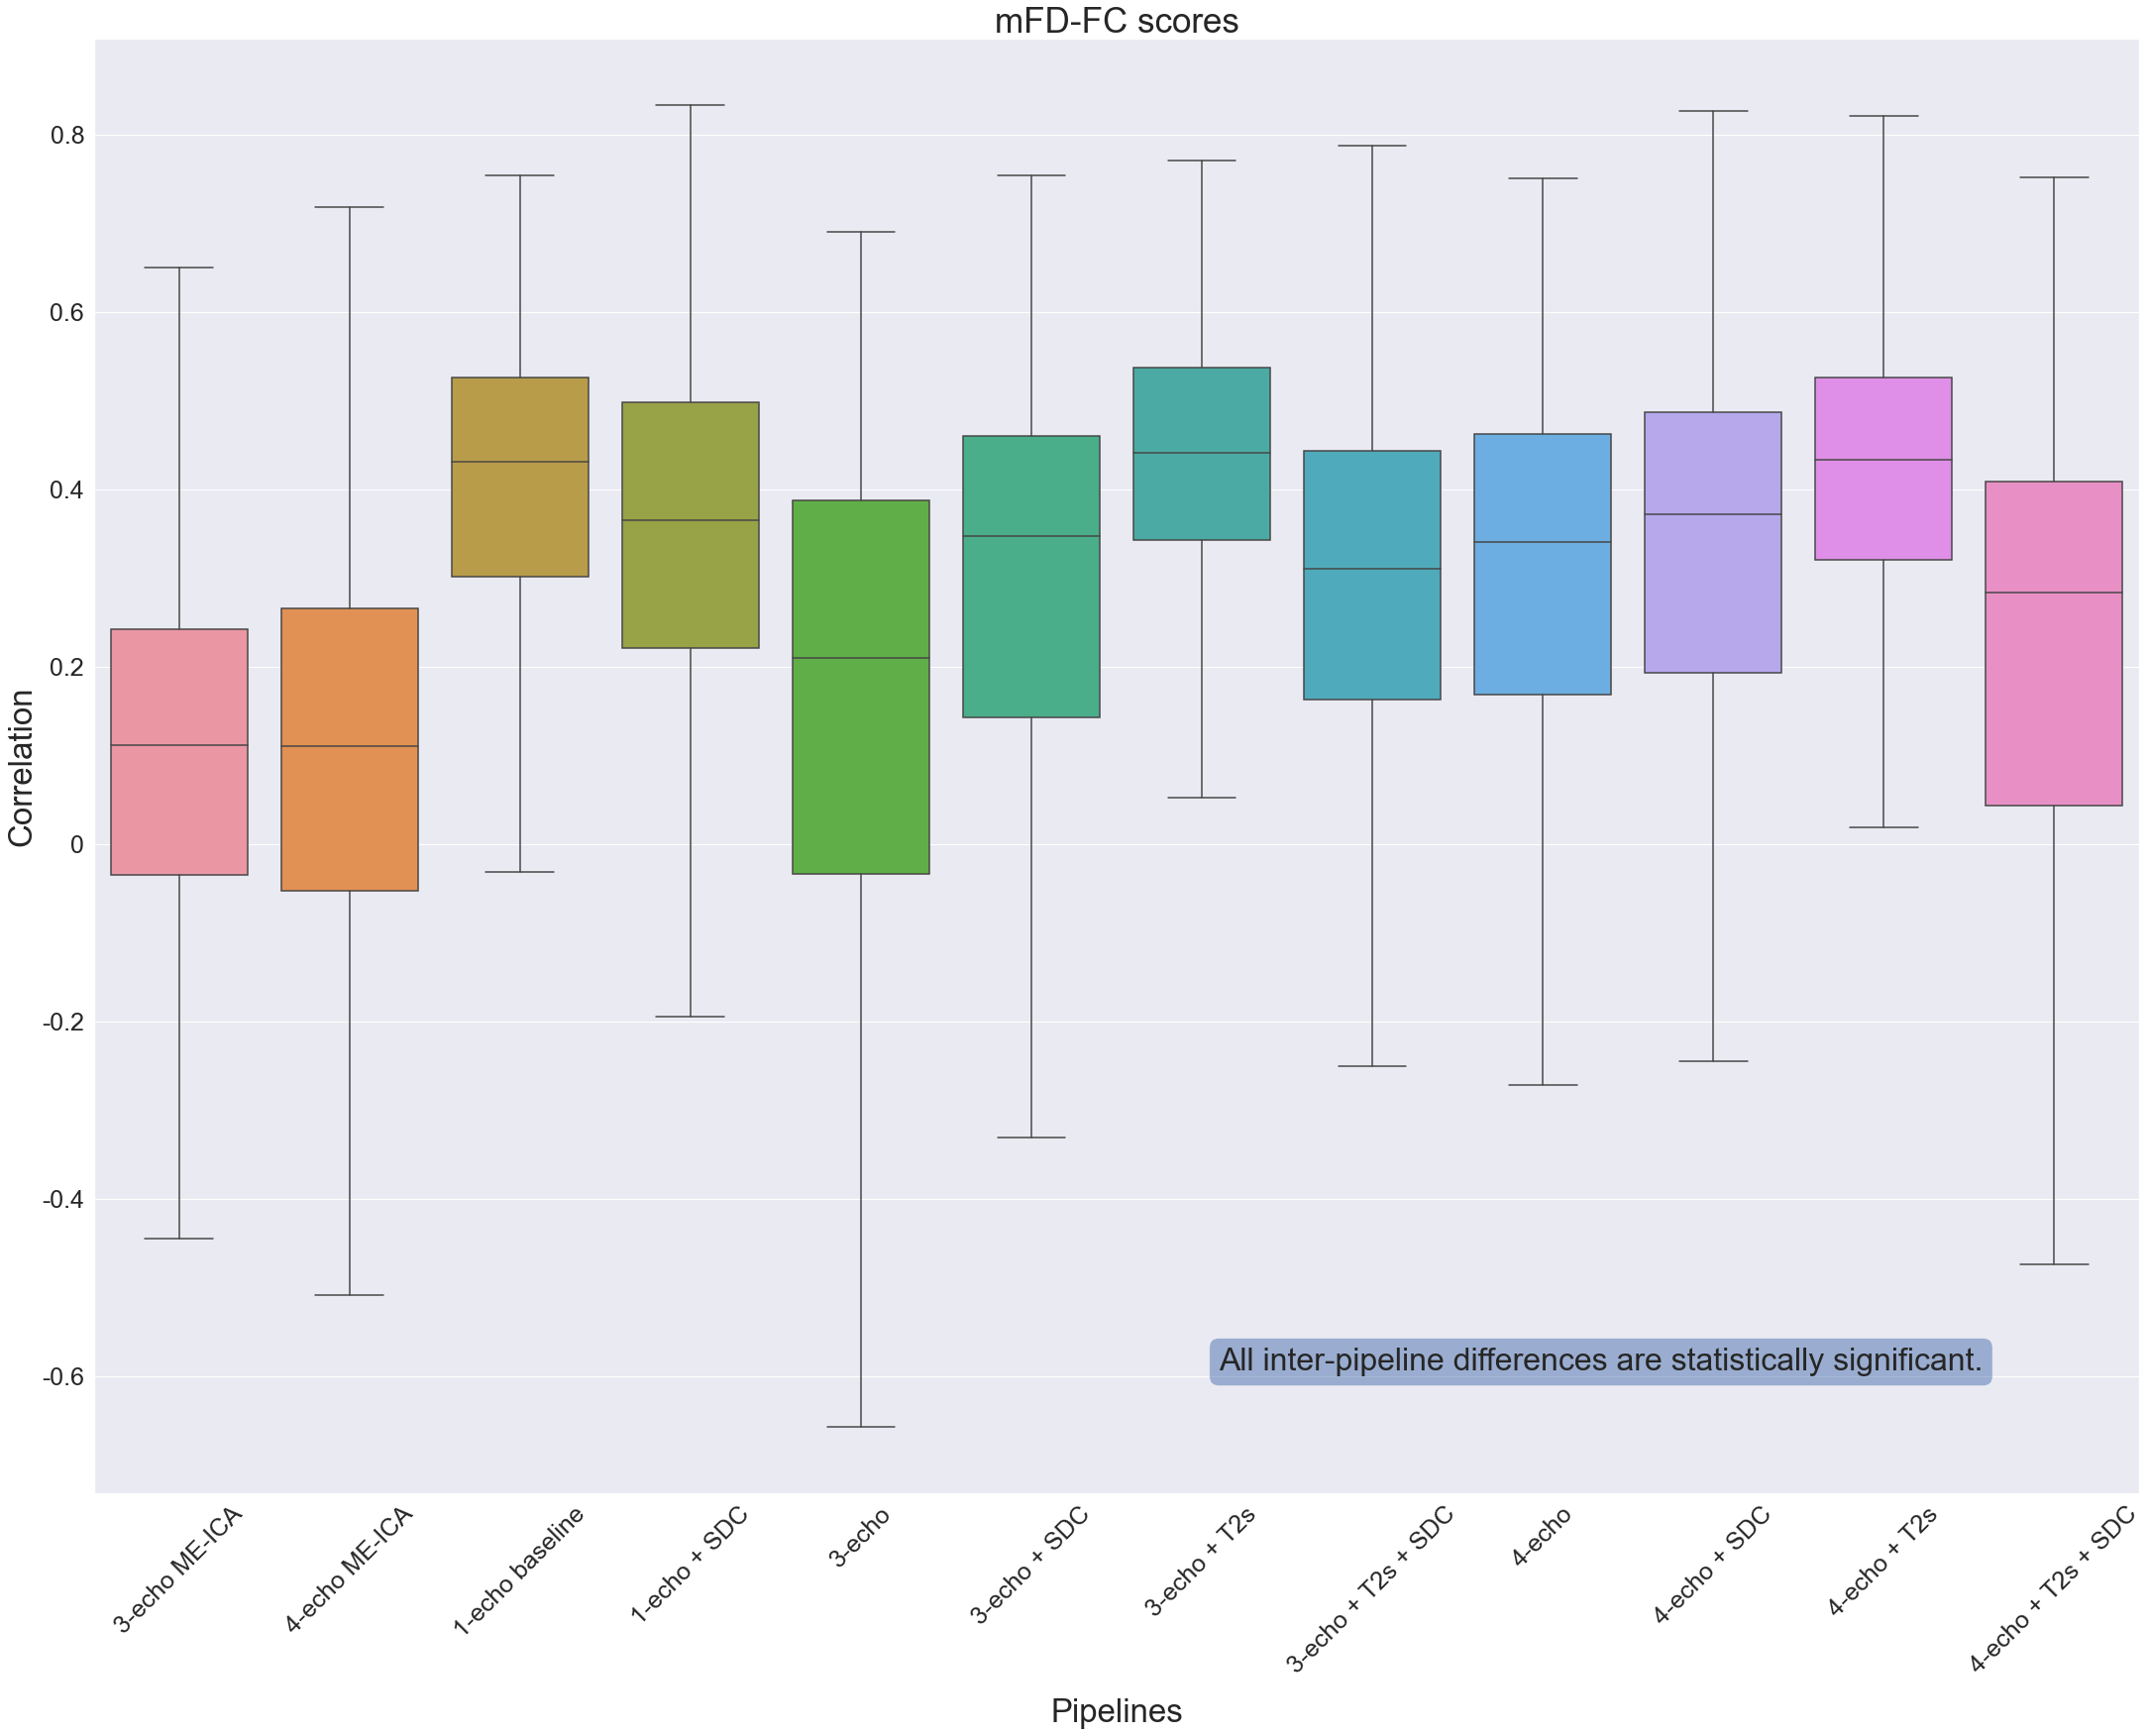

In [19]:
plt.rcParams["axes.labelsize"] = 33


# create the boxplot using seaborn instead of matplotlib
fig, ax = plt.subplots(figsize=(37,27))
sns.set(font_scale = 2)
ax.tick_params(axis='both', which='both', labelsize=10)
ax.set_xticklabels(new_pipeline_names, rotation=45, fontsize=25)
ax.set_yticklabels(['-0.8', '-0.6', '-0.4', '-0.2', '0', '0.2', '0.4', '0.6', '0.8'], rotation=0, fontsize=25)
ax.xaxis.labelpad = 20

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', 
             #facecolor='wheat', 
             alpha=0.5)

# place a text box in lower right in axes coords
textstr = 'All inter-pipeline differences are statistically significant.'
ax.text(0.55, 0.1, textstr, transform=ax.transAxes, fontsize=32,
        verticalalignment='top', bbox=props)

sb_ax = sns.boxplot(data=df_pipeline_list, #corr_matrix_list, 
                    order=new_pipeline_names, 
                    showfliers=False).set(
    xlabel='Pipelines', 
    ylabel='Correlation'
)

# plot with corrected p-values 
# CHANGE THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#test_results = add_stat_annotation(sb_ax, data=df_pipeline_list, order=pipeline_names,
#                                   box_pairs=[combo_list[n] for n in range(len(combo_list))],
#                                   perform_stat_test=False, pvalues=corrected_p_vals,
#                                   text_format='star',
#                                   loc='outside', verbose=2)

#plt.title('mFD-FC scores')
ax.set_title('mFD-FC scores',fontsize= 35) # title of plot

# plt.show()
plt.savefig('mFD-FC.png')

In [ ]:
# https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib